In [ ]:
# -.-|m { input: false }

# Generating beautiful HTML of notebook
!pip install pretty-jupyter
!jupyter nbconvert --to html --template pj getting-started-website.ipynb

This notebook provides some basic helper functions to work with the EUBUCCO database.         

Author: Felix Wagner (wagner@mcc-berlin.net), Nikola Milojevic-Dupont    
Date: 08.05.2022 (updated: 19.10.2022)

In [21]:
import urllib.request
import pandas as pd
import geopandas as gpd
from shapely import wkt
import matplotlib.pyplot as plt

## Download data

Visit https://eubucco.com/data/ and manually download building data for the city of Vichy, France or use our [API](https://api.eubucco.com/docs):

In [22]:
url = 'https://api.eubucco.com/v0.1/files/46c25dfc-aa93-49a5-bab8-df69d2fae81d/download'
path = 'Vichy.gpkg.zip'
urllib.request.urlretrieve(url, path)

('Vichy.gpkg.zip', <http.client.HTTPMessage at 0x7fc41a8854b0>)

## Load data

Use GeoPandas, it can even read zipped files without unzipping them!

In [32]:
df = gpd.read_file(path) # if you have unzipped the file removed .zip
df.head()

,id,height,age,type,id_source,type_source,geometry
0,v0.1-FRA.1.2.3.11_1-0,1.8,NaN,None,BATIMENT0000002201545772,Indifférencié,"POLYGON ((3813315.435 2578264.986, 3813320.501..."
1,v0.1-FRA.1.2.3.11_1-1,2.5,NaN,None,BATIMENT0000002201545773,Indifférencié,"POLYGON ((3813314.600 2578266.873, 3813312.160..."
2,v0.1-FRA.1.2.3.11_1-2,2.2,NaN,None,BATIMENT0000002201545774,Indifférencié,"POLYGON ((3813365.262 2578291.039, 3813360.612..."
3,v0.1-FRA.1.2.3.11_1-3,2.2,NaN,None,BATIMENT0000002201545775,Indifférencié,"POLYGON ((3813377.901 2578285.128, 3813362.431..."
4,v0.1-FRA.1.2.3.11_1-4,3.1,NaN,None,BATIMENT0000002201545776,Indifférencié,"POLYGON ((3813308.103 2578261.758, 3813306.462..."


### Load data in small chunks
If limited computational resources are available, the data can be read in chunks (of any size).

In [31]:
df = gpd.read_file(path, rows=1000)
df.tail()

,id,height,age,type,id_source,type_source,geometry
995,v0.1-FRA.1.2.3.11_1-995,2.5,NaN,None,BATIMENT0000002201689056,Indifférencié,"POLYGON ((3813076.434 2578803.380, 3813077.836..."
996,v0.1-FRA.1.2.3.11_1-996,9.0,1900.0,non-residential,BATIMENT0000002201689058,Commercial et services,"POLYGON ((3813088.148 2578891.694, 3813097.014..."
997,v0.1-FRA.1.2.3.11_1-997,20.0,NaN,non-residential,BATIMENT0000002201688763,Commercial et services,"POLYGON ((3812548.377 2578945.916, 3812560.541..."
998,v0.1-FRA.1.2.3.11_1-998,21.7,1900.0,residential,BATIMENT0000002201688769,Résidentiel,"POLYGON ((3812621.572 2578861.264, 3812614.153..."
999,v0.1-FRA.1.2.3.11_1-999,13.8,NaN,None,BATIMENT0000002201688779,Indifférencié,"POLYGON ((3812648.147 2578905.983, 3812645.797..."


## Plot data

<AxesSubplot: >

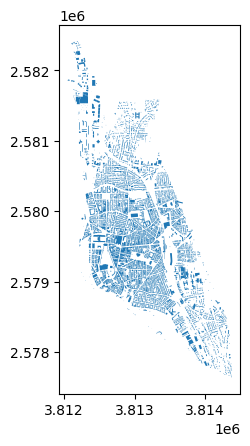

In [10]:
df.plot() # plot all building footprints from the file

<AxesSubplot: >

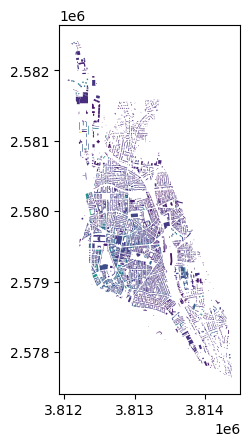

In [13]:
df.plot(column='height') # plot building footprints and color-code building heights

<AxesSubplot:>

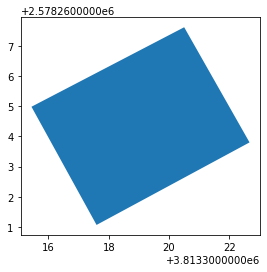

In [13]:
# plot individual building footprint
df.iloc[[0]].plot()

<AxesSubplot: >

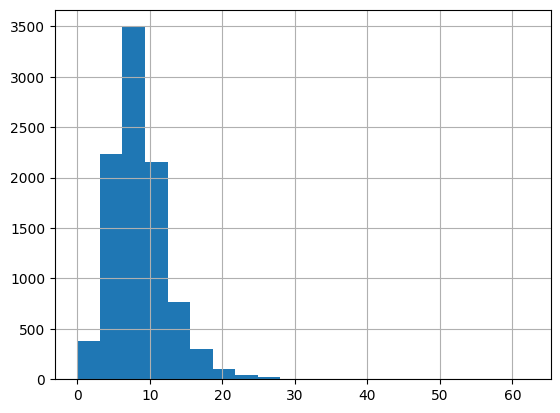

In [19]:
# plot distribution of building heights
df['height'].hist(bins=20)

## Matching regional boundaries
#### From GADM to individual buildings and vice versa: Adding country, region and city level information to the building level data.
If you want to find buildings only from a specific country, region or city, we recommend to use the table **admin-codes-matches-v0.1.csv** to filter for the country or region name and then choose the relevant dataset to download based on the id.   

In case you want to add the country, region and city names to the building level data, feel free to use the following function to match the admin-codes-matches-v0.1.csv table with the ids of your data.

In [7]:
def match_gadm_info(df_temp,df_overview):
    """ function to match country, region and city info from overview table with building level data
        df_temp (dataframe):=   building level dataframe
        df_overview:=           overview table
    """
    # remove numbering at end of id str 
    df_temp['id_temp'] = df_temp['id'].str.rsplit('-',1).apply(lambda x: x[0])
    # merge with overview file
    df_out = df.merge(df_overview, left_on='id_temp',right_on='id')
    # keep only relevant columns
    df_out = df_out[['id_x','id_source','country','region','city','height','age','type','type_source','geometry']]
    # rename back to 'id' and return
    return df_out.rename(columns={'idx_x':'id'})

In [10]:
# define path to overview file
path_overview_file = 'admin-codes-matches-v0.1.zip'

# read in overview file
df_overview = pd.read_csv(path_overview_file)

# check overview file
df_overview.head()

,id,country,region,city,source
0,v0.1-AUT.4.16.24_1,austria,Oberösterreich,Pilsbach,austria-osm
1,v0.1-AUT.3.15.42_1,austria,Niederösterreich,Wimpassing im Schwarzatale,austria-osm
2,v0.1-AUT.3.15.43_1,austria,Niederösterreich,Würflach,austria-osm
3,v0.1-AUT.3.15.44_1,austria,Niederösterreich,Zöbern,austria-osm
4,v0.1-AUT.3.17.1_1,austria,Niederösterreich,Sankt Pölten,austria-osm


In [17]:
# match gadm info to bldg lvl data and assign to df
df = match_gadm_info(df,df_overview)

# check df: we have some additional columns added now
df.head()

,id_x,id_source,country,region,city,height,age,type,type_source,geometry
0,v0.1-FRA.1.2.3.11_1-0,BATIMENT0000002201545772,france,Auvergne-Rhône-Alpes,Vichy,1.8,NaN,None,Indifférencié,"POLYGON ((3813315.435 2578264.986, 3813320.501..."
1,v0.1-FRA.1.2.3.11_1-1,BATIMENT0000002201545773,france,Auvergne-Rhône-Alpes,Vichy,2.5,NaN,None,Indifférencié,"POLYGON ((3813314.600 2578266.873, 3813312.160..."
2,v0.1-FRA.1.2.3.11_1-2,BATIMENT0000002201545774,france,Auvergne-Rhône-Alpes,Vichy,2.2,NaN,None,Indifférencié,"POLYGON ((3813365.262 2578291.039, 3813360.612..."
3,v0.1-FRA.1.2.3.11_1-3,BATIMENT0000002201545775,france,Auvergne-Rhône-Alpes,Vichy,2.2,NaN,None,Indifférencié,"POLYGON ((3813377.901 2578285.128, 3813362.431..."
4,v0.1-FRA.1.2.3.11_1-4,BATIMENT0000002201545776,france,Auvergne-Rhône-Alpes,Vichy,3.1,NaN,None,Indifférencié,"POLYGON ((3813308.103 2578261.758, 3813306.462..."
